In [11]:
#!/usr/bin/env python
# coding: utf-8

# In[28]:

import matplotlib
# matplotlib.use('nbAgg')  # 大小写无所谓 tkaGg ,TkAgg 都行
# matplotlib.use('tkAgg')  # 大小写无所谓 tkaGg ,TkAgg 都行
# matplotlib.use('default')  # 大小写无所谓 tkaGg ,TkAgg 都行
import matplotlib.pyplot as plt
import numpy as np
import math


# In[81]:


# car_path is directory of the log file
# log_car_file is the log file name
# car_path = r"D:\Z_zDCVS_space\7675_add_goal_correction\7675_20220303_2\16_0303mcu3_dx0.25/"
# car_path = r"D:\Z_DesayWorkSpace\8008_aui_parking\8008_20220409\bvs_2/"  # standard
car_path = r"D:\Z_DesayWorkSpace\7957_apa_onsite\7957_20220414\2/"

# log_car_file = car_path+"session.log"
# log_car_file = car_path+"logfile.txt"
# log_car_file = car_path+"logfile_all.txt"
# log_car_file = car_path+"pc_log.txt"



# paths to computed_path.txt
path_car_file = car_path+"computed_path.txt"
# path_car_file2 = car_path+"computed_path2.txt"
# path_car_file3 = car_path+"computed_path3.txt"
# path_car_file4 = car_path+"computed_path4.txt"
# path_car_file = car_path+"computed_path_reg.txt"

# paths to naive_trajectory_fixed_dtXY.txt
# traj_car_file = car_path+"naive_trajectory_fixed_dtXY.txt"


# In[89]:
print("log path: ", log_car_file)
# print("car path: ", path_car_file)


# car data
odom_x_car = []         # odometry x
odom_y_car = []         # odometry y
odom_theta_car = []     # odometry theta (angle)
odom_phi_car = []       # odometry steering
odom_start_x = []
odom_start_y = []
odom_goal_x = []        # odometry x at goal reached
odom_goal_y = []        # odometry y at goal reached
apa_x_car = []
apa_y_car = []
apa_theta_car = []
control_v_car = []      # ComputeControlValue speed
control_steer_car = []  # ComputeControlValue steering
control_w_car = []      # ComputeControlValue steering velocity
control_car_time = []   # ComputeConrolValue timestamp
pub_v_car = []          # PubControl speed
pub_steer_car = []
pub_dist_car = []
pub_car_time = []       # PubControl timestamp
expect_x_car = []       # ComputeControlValue expected x
expect_y_car = []       # ComputeControlValue expected y
car_time = []           # cnn time
parking_points_x = []
parking_points_y = []

traj_cache_car_x = []   # top of trajectory cache x
traj_cache_car_y = []   # top of trajectory cache x
traj_car_time = []      # trajectory timestamp

true_goal_x = []
true_goal_y = []
true_goal_theta = []

odom_car_control_x = []
odom_car_control_y = []

# log timestamps for runtime calculations
mpc_time_car = []
frame_times_car = []
odom_times_car = []
apa_rc_speed = []
apa_rc_angle = []
apa_rc_times = []
rc_time = []


forward_mid_x = []
forward_mid_y = []
forward_mid_theta = []

reverse_mid_x = []
reverse_mid_y = []
reverse_mid_theta = []


# ParkingMiddleGoals: convert goal to estimated parking spot center
slot_center_x = []
slot_center_y = []
slot_center_theta = []

slot_center_apa_x = []
slot_center_apa_y = []
slot_center_apa_theta = []


# odometry pick point
odom_pick_x = []
odom_pick_y = []
odom_pick_theta = []
odom_buffer = []  # length of 2


flag_number = 15
flag = [False for x in range(flag_number)]

commit = []

# Parse Car log file
with (open(log_car_file,"r")) as f:
    begin_t = 0.0
    time_set = False
    current_t = 0
    control_begin = False
    get_cache = False
    frame_start = 0
    frame_start_apa = 0
    frame_end = 0
    odom_start = 0
    
    current_log_time = 0
    current_log_time1 = 0
    
    line_num = 0
    
    start_goal = False
    goal_reached = False
    
    
    for line in f:

        if "[tsl]" in line:
            line = line.replace("[tsl]", "")
        
        line_num += 1
        
        '''if ("[info]" in line and len(line.split()[1].split(':')) > 2):
            raw_sec = line.split()[1].split(':')[2]
            raw_min = line.split()[1].split(':')[1]
            current_log_time = float(raw_sec.replace(']','')) + 60*float(raw_min)
            raw_times = line.split(']')[0].split(':')
            ms = float(raw_times[3])
            s = float(raw_times[2])
            m = float(raw_times[1])
            #current_log_time = 0.001*ms + s + 60*m'''
        
        # save current cnn timestamp -- 1
        if ("[info] Odometry localization inpput: <" in line):
            flag[0] = True
#             print("1. [info] Odometry localization inpput: in line")
            try:
                raw_t = line.split()[6]
                raw_t = raw_t.split('<')[1]
                raw_t = raw_t.replace('>','')
                t = int(raw_t)
                current_t = t
            except IndexError:
                print (line_num)
    
        # parse odometry -- 2
        if ("Current Pose(x, y, theta, phi):" in line):
            flag[1] = True
#             print("2. Current Pose(x, y, theta, phi): inline")
            try:
                raw_x = line.split()[8]
                raw_x = raw_x.replace('(','').replace(',','')
                raw_y = line.split()[9]
                raw_y = raw_y.replace(',','').replace(')','')
                raw_theta = line.split()[10]
                raw_theta = raw_theta.replace(',','')
                raw_phi = line.split()[11]
                raw_phi = raw_phi.replace(')','')
                odom_x_car.append(float(raw_x))
                odom_y_car.append(float(raw_y))
                odom_theta_car.append(float(raw_theta))
                if (control_begin):
                    odom_phi_car.append(float(raw_phi))
                car_time.append(current_t)
                if (control_begin):
                    odom_car_control_x.append(float(raw_x))
                    odom_car_control_y.append(float(raw_y))
                if (start_goal):
                    odom_start_x.append(float(raw_x))
                    odom_start_y.append(float(raw_y))
                    start_goal = False
                if (goal_reached):
                    odom_goal_x.append(float(raw_x))
                    odom_goal_y.append(float(raw_y))
                    goal_reached = False
                
                # findout odom pick-point(gear change point)  TBC 这个逻辑判断有些复杂，暂时先不写
                
                
            except ValueError:
                print (line_num)
                continue
           
        # APAPose -- 3
        elif ("APAPose Pose(x, y, theta, phi):" in line):
            flag[2] = True
#             print("3. APAPose Pose(x, y, theta, phi): in line")
            try:
                raw_x = line.split()[8]
                raw_x = raw_x.replace('(','').replace(',','')
                raw_y = line.split()[9]
                raw_y = raw_y.replace(',','').replace(')','')
                raw_theta = line.split()[10]
                raw_theta = raw_theta.replace(',','')
                apa_x_car.append(float(raw_x))
                apa_y_car.append(float(raw_y))
                apa_theta_car.append(float(raw_theta))
                
            except ValueError:
                print (line_num)
                continue
        
        # parse ComputeControlValue control output -- 4
        elif ("Computed command:" in line):
            flag[3] = True
#             print("4. Computed command: in line")
            control_begin = True
            try:
                raw_v = line.split()[5]
                raw_w = line.split()[6]
                raw_steer = line.split()[7]
                control_v_car.append(float(raw_v))
                control_w_car.append(float(raw_w))
                control_steer_car.append(float(raw_steer))
                control_car_time.append(current_t)
                if (frame_start == 0):
                    frame_start = current_log_time
                else:
                    frame_time = current_log_time - frame_start
                    if (frame_time > 0):
                        frame_times_car.append(frame_time)
                    frame_start = 0
            except ValueError:
                print (line_num)
                continue
            
        # control start -- 5
        elif (">>> control start" in line):
            flag[4] = True
#             print("5. >>> control start")
            start_mpc = current_log_time
            
        # ComputeControlValue -- 6
        elif ("ComputeControlValueStep::getCommandActive printing" in line):
            flag[5] = True
#             print("6. ComputeControlValue:: in line")
            get_cache = True
            
        # trajectory cache -- 7
        elif ("[info] trajectory cache" in line and get_cache):
            flag[6] = True
#             print("7. [info] trajectory cache in line")
            try:
                raw_x = line.split()[5]
                raw_y = line.split()[6]
                traj_cache_car_x.append(float(raw_x))
                traj_cache_car_y.append(float(raw_y))
                traj_car_time.append(current_t)
                get_cache = False
            except ValueError:
                print (line_num)
                continue
        
        # parse PubControl controls -- 8
        elif ("PubControl speed" in line):
            flag[7] = True
#             print("8. PubControl speed in line")
            try:
#                 print(line.split())
                raw_v = line.split()[4].split("=")[1]
                raw_steer = line.split()[5].split("=")[1]
                raw_dist = line.split()[6].split("=")[1]
                pub_v_car.append(float(raw_v))
                pub_steer_car.append(float(raw_steer))
                pub_dist_car.append(float(raw_dist))
                pub_car_time.append(current_t)
            except IndexError:
                print (line_num)
                continue
            
        # <<< end -- 9
        elif ("<<< end" in line):
            flag[8] = True
#             print("9. <<< end in line")
            if (start_mpc > 0):
                mpc_time_car.append(current_log_time - start_mpc)
                    
        # Expect pose -- 10
        elif ("Expect pose:" in line):
            flag[9] = True
#             print("10. Expect pose: in line")
            raw_x = line.split()[5].replace(',','')
            raw_y = line.split()[6].replace(',','')
            try:
                expect_x_car.append(float(raw_x))
                expect_y_car.append(float(raw_y))
            except ValueError:
                expect_x_car.append(0)
                expect_y_car.append(0)
                 
        # apa rc -- 11
        elif ("apa rc" in line and len(line.split())>4):
            flag[10] = True
#             print("11. apa rc in line ")
            try:
                raw_speed = line.split(",")[1].split()[2]
                raw_angle = line.split(",")[2].split()[2]
                apa_rc_speed.append(float(raw_speed))
                apa_rc_angle.append(float(raw_angle))
                rc_time.append(current_t)

                if (frame_start_apa == 0):
                    frame_start_apa = current_log_time
                else:
                    frame_time = current_log_time - frame_start_apa
                    if (frame_time > 0):
                        apa_rc_times.append(frame_time)
                    frame_start_apa = 0
            except IndexError:
                print (line_num)
                continue
                
        # check start pose -- 12
        elif ("Computing trajectory size" in line):
            flag[11] = True
#             print("12. Computing trajectory size in line")
            start_goal = True
                
        # check if goal reached -- 13
        elif ("The goal is reached" in line):
            flag[12] = True
#             print("13. The goal is reached in line")
            goal_reached = True
            
        # get ABCD parking points -- 14
        elif ("ParkingMiddleGoals: parking points" in line):
            flag[13] = True
#             print("14. ParkingMiddleGoals: parking points in line")
            raw_ABCD = line.split()
            parking_points_x.append(float(raw_ABCD[7]))
            parking_points_y.append(float(raw_ABCD[8]))
            parking_points_x.append(float(raw_ABCD[10]))
            parking_points_y.append(float(raw_ABCD[11]))
            parking_points_x.append(float(raw_ABCD[13]))
            parking_points_y.append(float(raw_ABCD[14]))
            parking_points_x.append(float(raw_ABCD[16]))
            parking_points_y.append(float(raw_ABCD[17]))
            
        # get true goal from shared state - 15
        elif ("ParkingMiddleGoals: received goal from sharedstate" in line):
            flag[14] = True
            print ("ParkingMiddleGoals: received goal from sharedstate ok")
            print(line.split())
            raw_true_x = line.split()[8]
            raw_true_y = line.split()[9]
            raw_true_theta = line.split()[10]
            true_goal_x.append(float(raw_true_x))
            true_goal_y.append(float(raw_true_y))
            true_goal_theta.append(float(raw_true_theta))
            

            
        ################ newly added info ##############
        
        # 8. forward mid point
        elif ("getParallelPath: forward mid point" in line):
            print("8x. getParallelPath: forward mid point -- ok")
            raw = line.split()
#                 print(raw)
            raw_x = line.split()[7]
            raw_y = line.split()[8]
            raw_theta = line.split()[9]
            forward_mid_x.append(float(raw_x))
            forward_mid_y.append(float(raw_y))
            forward_mid_theta.append(float(raw_theta))

        # 9. reverse mid point
        elif ("getParallelPath: reverse mid point" in line):
            print("9x. getParallelPath: reverse mid point -- ok")
            raw = line.split()
#                 print(raw)
            raw_x = line.split()[7]
            raw_y = line.split()[8]
            raw_theta = line.split()[9]
            reverse_mid_x.append(float(raw_x))
            reverse_mid_y.append(float(raw_y))
            reverse_mid_theta.append(float(raw_theta))

        # 10. slot center
        elif ("ParkingMiddleGoals: convert goal to estimated parking spot center" in line):
            print ("ParkingMiddleGoals: convert goal to estimated parking spot center -- ok")
            raw = line.split()
            print(raw)
            raw_x = line.split()[11]
            raw_y = line.split()[12]
            raw_theta = line.split()[13]
            slot_center_x.append(float(raw_x))
            slot_center_y.append(float(raw_y))
            slot_center_theta.append(float(raw_theta))
            
        # 10. slot center apa
        elif ("ParkingMiddleGoals: parking spot center from APA" in line):
            print ("ParkingMiddleGoals: parking spot center from APA -- ok")
            raw = line.split()
            print(raw)
            raw_x = line.split()[9].split("(")[1]
            raw_y = line.split()[10].split(")")[0]
#             raw_theta = line.split()[13]
            slot_center_apa_x.append(float(raw_x))
            slot_center_apa_y.append(float(raw_y))
#             slot_center_theta.append(float(raw_theta))      

        # 11. commit
        elif ("Build info: branch:master commit" in line):
            print("commit -- ok")
            print(line.split()[-1].split(":")[-1])
            commit.append(line.split()[-1].split(":")[-1])
            

# check  INFO line existance
print("\n" + "*"*30)
for i in range(14):
    print(i + 1, flag[i])
print("*"*30 + "\n")
            
            
# dt = car_time[len(car_time)-1] - car_time[0]
# print ("average ComputeOdom ms per frame: {}".format(dt/len(car_time)))

# dt = control_car_time[len(control_car_time)-1] - control_car_time[0]
# print ("average ComputeControlValue ms per frame: {}".format(dt/len(control_car_time)))



log path:  D:\Z_DesayWorkSpace\7957_apa_onsite\7957_20220414\2/logfile_all.txt
commit -- ok
dcc8cee2
ParkingMiddleGoals: received goal from sharedstate ok
['[2021-04-10', '00:09:52.506]', '[info]', 'ParkingMiddleGoals:', 'received', 'goal', 'from', 'sharedstate', '7.67099', '5.64341', '-1.54622']
ParkingMiddleGoals: convert goal to estimated parking spot center -- ok
['[2021-04-10', '00:09:52.506]', '[info]', 'ParkingMiddleGoals:', 'convert', 'goal', 'to', 'estimated', 'parking', 'spot', 'center', '7.71178', '3.98392', '-1.54622']
ParkingMiddleGoals: parking spot center from APA -- ok
['[2021-04-10', '00:09:52.508]', '[info]', 'ParkingMiddleGoals:', 'parking', 'spot', 'center', 'from', 'APA', '(7.69754', '4.56321)']

******************************
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True
10 True
11 False
12 True
13 True
14 True
******************************



In [12]:
# from math import abs

# load computed path files
try:
    path_carx = []
    path_cary = []
#     path_pick_x = []
#     path_pick_y = []
#     raw_steer_buffer = []
    

    with (open(path_car_file,"r")) as f:
        for line in f:
            if ("x y" not in line):
                path_carx.append(float(line.split()[0]))
                path_cary.append(float(line.split()[1]))
                

                # 应该是 记录的是 odom 而不是 computed_path !!!
#                 # find pick point, everything theta changes its sign
#                 raw_steer = float(line.split()[3])
#                 raw_steer_buffer.append(raw_steer)
#                 print("raw_steer:\t", raw_steer)
#                 print("raw_steer abs:\t", abs(raw_steer))
#                 sign_steer = raw_steer / abs(raw_steer)
                
#                 # 保存至多两个数据在 raw_steer_buffer 中
                
                
#                 raw_steer_buffer.pop(2)
                
                
except:
    print("compute path 1 error")            


try:
    path2_carx = []
    path2_cary = []
    with (open(path_car_file2,"r")) as f:
        for line in f:
            if ("x y" not in line):
                path2_carx.append(float(line.split()[0]))
                path2_cary.append(float(line.split()[1]))
except:
    print("compute path 2 error")

compute path 2 error


odom length:	 3075
odom length half:	 1537
parking_points_x:	 [6.55372, 6.34925, 8.93377, 8.95342]
parking_points_y:	 [2.2588, 6.77822, 6.90788, 2.30792]

true_goal_x:	 [7.67099]
true_goal_y:	 [5.64341]
true_goal_t:	 [-1.54622]

forward_mix_x:	 []
forward_mix_y:	 []
forward_mid_t:	 []

reverse_mix_x:	 []
reverse_mix_y:	 []
reverse_mid_t:	 []

slot_center_x:	 [7.71178]
slot_center_y:	 [3.98392]
slot_center_t:	 [-1.54622]

slot_center_apa_x:	 [7.69754]
slot_center_apa_y:	 [4.56321]
slot_center_apa_t:	 [-1.54622]

car_body_box_rm_1_x_wc len:  6
car_body_box_rm_1_wc len:  6
[[6.73252043]
 [0.42672454]
 [1.        ]]
6.732520431076708 0.4267245353972636
[[4.30248]
 [4.09449]
 [1.     ]]


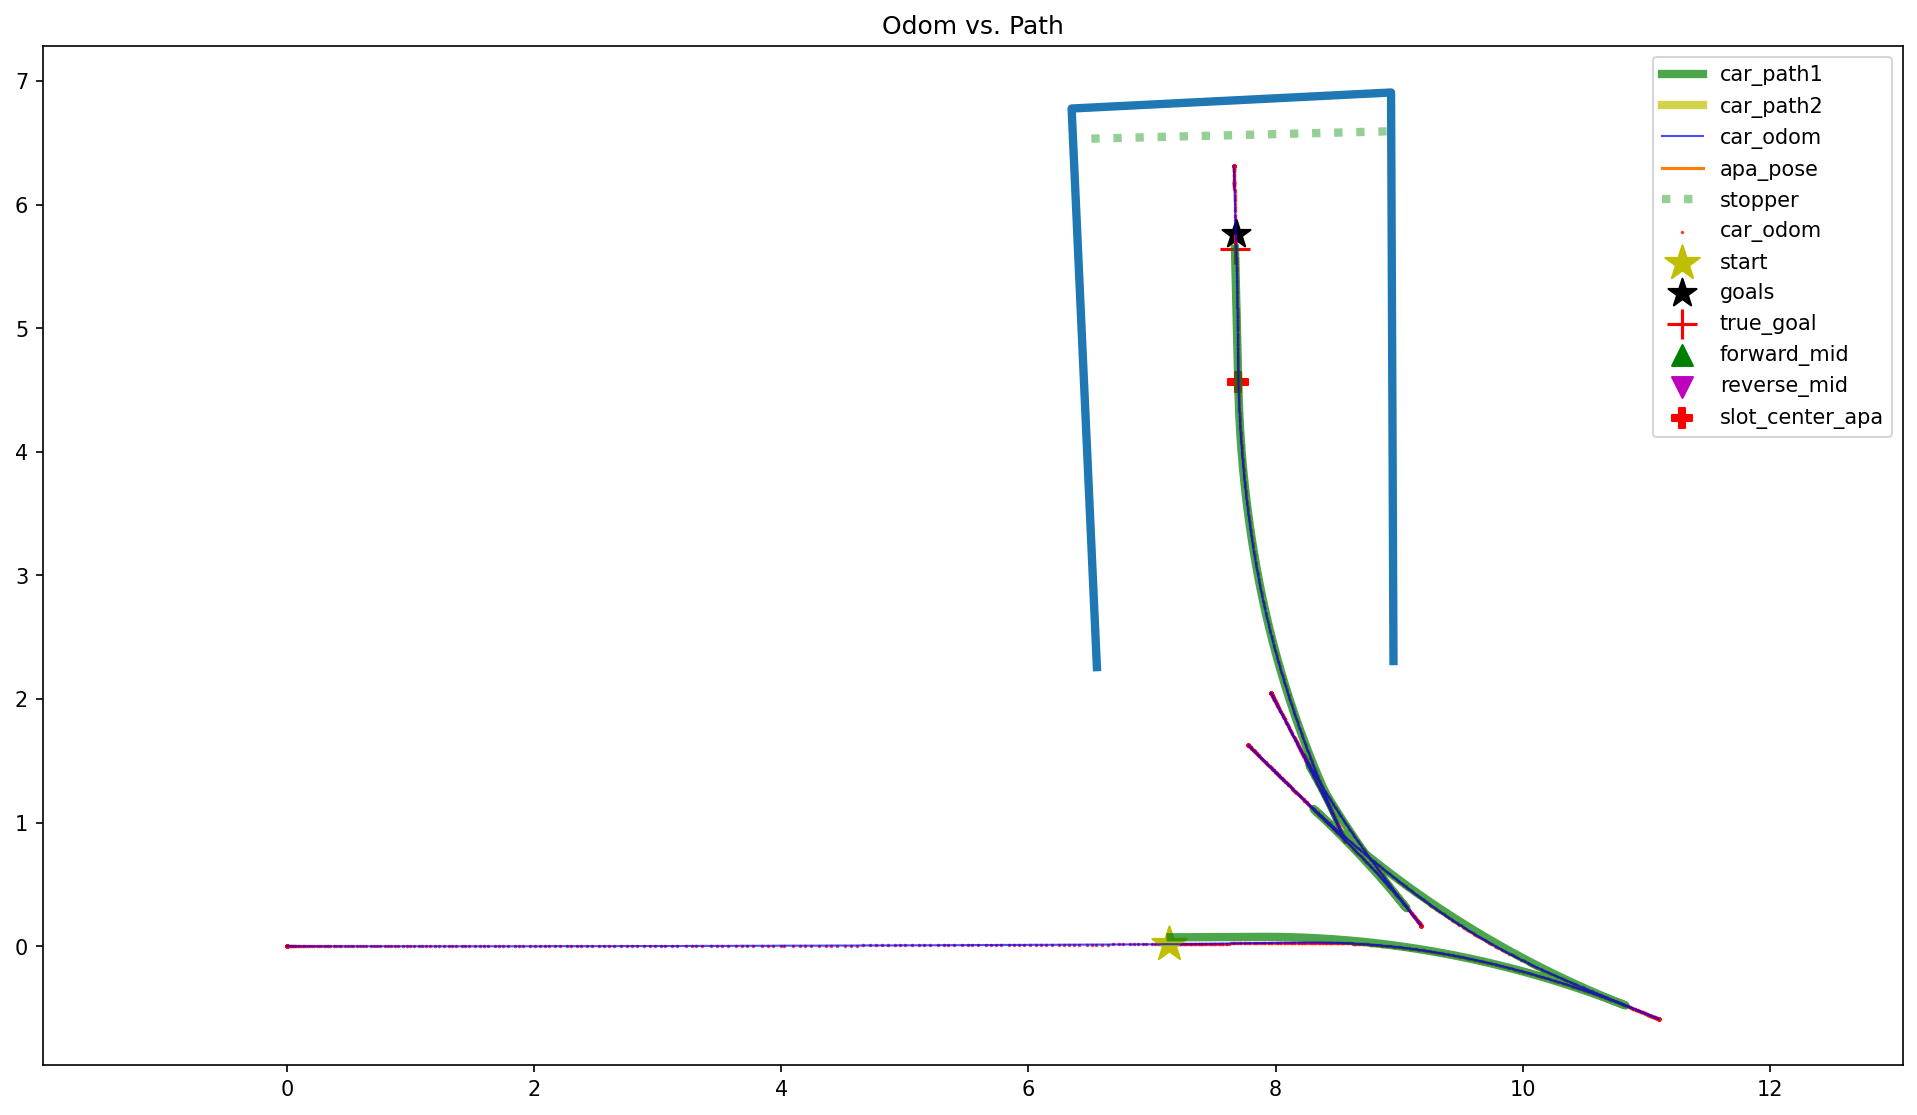

In [13]:
# compare odometry and computed path (Car)
try:
    pillar_x = parking_points_x[0] + 4.7
    pillar_y = parking_points_y[0] - 7.45
except:
    print("no pillar value received")
    
# plt.figure(figsize=(8,10))
plt.figure(figsize=(16, 9), dpi=150)
# plt.figure(dpi=150)

plt.axis('equal')


# 1. plot computed path
plt.plot(path_carx, path_cary, label="car_path1", linewidth=4, alpha=0.7, color='g')
plt.plot(path2_carx, path2_cary, label="car_path2", linewidth=4, alpha=0.7, color='y')
# plt.plot(path3_carx, path3_cary, label="car_path3", linewidth=4)
#plt.plot(path4_carx, path4_cary, label="car_path4", linewidth=4)

# 2. plot odometry
print("odom length:\t", len(odom_x_car))
print("odom length half:\t", int(len(odom_x_car)/2))
plt.plot(odom_x_car, odom_y_car, label="car_odom", color="b", alpha=0.7, linewidth=1)
# plt.scatter(odom_x_car[0:700], odom_y_car[0:700], label="car_odom", color="b", alpha=0.7, s=1)
plt.scatter(odom_x_car, odom_y_car, label="car_odom", color="r", alpha=0.7, s=0.5)

# 3. plot odom start, goal
plt.scatter(odom_start_x, odom_start_y, label="start", marker='*', color='y', s=300)
plt.scatter(odom_goal_x, odom_goal_y, label="goals", marker='*', color='k', s=200)

# 4. plot parking slot points
plt.plot(parking_points_x, parking_points_y, linewidth=4)
print("parking_points_x:\t", parking_points_x)
print("parking_points_y:\t", parking_points_y)


# # 5. plot pillars
# try:
#     plt.plot(pillar_x, pillar_y, marker='.', markersize=100)
# except:
#     print("cannot plot pillar")

# 6. plot apa car post
plt.plot(apa_x_car, apa_y_car, label="apa_pose")

# 7. plot true goal
# plt.plot(true_goal_x, true_goal_y, label="true_goal", color="r")
plt.scatter(true_goal_x, true_goal_y, label="true_goal", marker='+', color='r', s=200)
print()
print("true_goal_x:\t", true_goal_x)
print("true_goal_y:\t", true_goal_y)
print("true_goal_t:\t", true_goal_theta)

# 4. plot forward mid
plt.scatter(forward_mid_x, forward_mid_y, label="forward_mid", marker='^', color='g', s=100)
print()
print("forward_mix_x:\t", forward_mid_x)
print("forward_mix_y:\t", forward_mid_y)
print("forward_mid_t:\t", forward_mid_theta)


# 5. plot reverse mid
plt.scatter(reverse_mid_x, reverse_mid_y, label="reverse_mid", marker='v', color='m', s=100)
print()
print("reverse_mix_x:\t", reverse_mid_x)
print("reverse_mix_y:\t", reverse_mid_y)
print("reverse_mid_t:\t", reverse_mid_theta)


###############################################################################
### additon info data plot

# 6. slot center
# plt.scatter(slot_center_x, slot_center_y, label="slot_center", marker='o', color='r', s=100)
print()
print("slot_center_x:\t", slot_center_x)
print("slot_center_y:\t", slot_center_y)
print("slot_center_t:\t", slot_center_theta)

# 7. slot center apa
plt.scatter(slot_center_apa_x, slot_center_apa_y, label="slot_center_apa", marker='P', color='r', s=100)
print()
print("slot_center_apa_x:\t", slot_center_apa_x)
print("slot_center_apa_y:\t", slot_center_apa_y)
print("slot_center_apa_t:\t", slot_center_theta) # use slot_center_theta


# 8. parking points
# plt.scatter(parking_points_x, parking_points_y, label="parking_points", marker='o', color='r', s=100)
# print()
# print("parking_points_x:\t", parking_points_x)
# print("parking_points_x:\t", parking_points_y)
# # print("slot_center_apa_t:\t", parking_points_theta)


###############################################################################
### points transform

import numpy as np
from math import sqrt, cos, sin, radians, atan2, degrees

# 9. plot car box at init pose
car_body_box_init_x = [4.26, 4.26, -0.94, -0.94, 4.26, 0] # last is rear-wheel-center
car_body_box_init_y = [-1.1, 1.1, 1.1, -1.1, -1.1, 0] # last is rear-wheel-center
# plt.plot(car_init_box_x[0:5], car_init_box_y[0:5], linewidth=4)
# plt.scatter(car_init_center_x[-1], car_init_center_y[-1], color='g', s=100)

# 将 所有 computed_path(x, y) 写入 path_list_cc
car_body_box_init_cc = []
for i in range(len(car_body_box_init_x)):
    x = car_body_box_init_x[i]
    y = car_body_box_init_y[i]
    z = 1
    tmp_path_point = np.array([
        [x],
        [y],
        [1],
    ])
    car_body_box_init_cc.append(tmp_path_point)

# print(car_body_box_cc)

# 10. 旋转平移矩阵: T_R matrix
# reverse_mix_x:	 [3.4838, 4.30248]
# reverse_mix_y:	 [3.38852, 4.09449]
# reverse_mid_t:	 [-0.032905, -0.73296]

# T_R for reverse_mid 1
theta_rm_1 = -0.73296
t_x_rm_1 = 4.30248
t_y_rm_1 = 4.09449

T_R_rm_1 = np.array([
    [cos(theta_rm_1), -sin(theta_rm_1), t_x_rm_1],
    [sin(theta_rm_1), cos(theta_rm_1), t_y_rm_1],
    [0, 0, 1],
])


car_body_box_rm_1_wc = []
car_body_box_rm_1_x_wc = []
car_body_box_rm_1_y_wc = []
for i in range(len(car_body_box_init_cc)):
    tmp_point_wc = T_R_rm_1.dot(car_body_box_init_cc[i])
    car_body_box_rm_1_wc.append(tmp_point_wc)
    tmp_x_wc = tmp_point_wc[0][0]
    tmp_y_wc = tmp_point_wc[1][0]
    car_body_box_rm_1_x_wc.append(tmp_x_wc)
    car_body_box_rm_1_y_wc.append(tmp_y_wc)

print()
print("car_body_box_rm_1_x_wc len: ", len(car_body_box_rm_1_x_wc))
    

print("car_body_box_rm_1_wc len: ", len(car_body_box_rm_1_wc))
print(car_body_box_rm_1_wc[0])
print(car_body_box_rm_1_wc[0][0][0], car_body_box_rm_1_wc[0][1][0])  # x, y
print(car_body_box_rm_1_wc[5])


# T_R for reverse_mid 2
theta_rm_2 = -0.032905
t_x_rm_2 = 3.4838
t_y_rm_2 = 3.38852

T_R_rm_2 = np.array([
    [cos(theta_rm_2), -sin(theta_rm_2), t_x_rm_2],
    [sin(theta_rm_2), cos(theta_rm_2), t_y_rm_2],
    [0, 0, 1],
])



car_body_box_rm_2_wc = []
car_body_box_rm_2_x_wc = []
car_body_box_rm_2_y_wc = []
for i in range(len(car_body_box_init_cc)):
    tmp_point_wc = T_R_rm_2.dot(car_body_box_init_cc[i])
    car_body_box_rm_2_wc.append(tmp_point_wc)
    tmp_x_wc = tmp_point_wc[0][0]
    tmp_y_wc = tmp_point_wc[1][0]
    car_body_box_rm_2_x_wc.append(tmp_x_wc)
    car_body_box_rm_2_y_wc.append(tmp_y_wc)


    
# T_R for stoper

stopper_x = [-2, -2]
stopper_y = [1.25, -1.25]
stopper_cc = []

for i in range(len(stopper_x)):
    x = stopper_x[i]
    y = stopper_y[i]
    z = 1
    tmp_path_point = np.array([
        [x],
        [y],
        [1],
    ])
    stopper_cc.append(tmp_path_point)
    
# stopper 是以原点在圆心的坐标系为基准，slot_center 点是旋转平移矩阵
# slot_center_x:	 [6.49217]
# slot_center_y:	 [3.2895]
# slot_center_t:	 [-0.032905]
# theta_stopper = -0.032905
# t_x_stopper = 6.49217
# t_y_stopper = 3.2895
theta_stopper = slot_center_theta[0]
t_x_stopper = slot_center_apa_x[0]
t_y_stopper = slot_center_apa_y[0]

T_R_stopper = np.array([
    [cos(theta_stopper), -sin(theta_stopper), t_x_stopper],
    [sin(theta_stopper), cos(theta_stopper), t_y_stopper],
    [0, 0, 1],
])



stopper_wc = []
stopper_x_wc = []
stopper_y_wc = []
for i in range(len(stopper_cc)):
    tmp_point_wc = T_R_stopper.dot(stopper_cc[i])
    stopper_wc.append(tmp_point_wc)
    tmp_x_wc = tmp_point_wc[0][0]
    tmp_y_wc = tmp_point_wc[1][0]
    stopper_x_wc.append(tmp_x_wc)
    stopper_y_wc.append(tmp_y_wc)
    
# draw stopper
plt.plot(stopper_x_wc, stopper_y_wc, 
     linewidth=4, alpha=0.5, linestyle="dotted", label="stopper")
    
###############################################################################
### plottransform    

def draw_cc2wc_car_body(points_list_x_wc, points_list_y_wc):
    plt.plot(points_list_x_wc[0:5], 
         points_list_y_wc[0:5], 
         linewidth=4, color='m', alpha=0.3)
    plt.scatter(points_list_x_wc[-1], points_list_y_wc[-1], color='m', s=100, alpha=0.3)
    
    
# draw_cc2wc_car_body(car_body_box_rm_1_x_wc, car_body_box_rm_1_y_wc)
# draw_cc2wc_car_body(car_body_box_rm_2_x_wc, car_body_box_rm_2_y_wc)


###############################################################################


plt.legend(loc="best")
# plt.xlim(-1,9)
# plt.ylim(-6,10)


plt.title("Odom vs. Path")

plt.show()


# plot additional objects on path and odom graph

In [14]:
##############################################################################################################
######################### define affine matrix
    
import numpy as np
from math import sqrt, cos, sin, radians, atan2, degrees

def cc2wc_transform(point_list_cc_x, point_list_cc_y, point_list_wc_x, point_list_wc_y, tr_theta, tr_x, tr_y):
    """ affine transformation matrix
    transform points in cc frame to wc frame using rotation & translation matrix T_R
    """
    point_list_cc = []
    point_list_wc = []
    
    for i in range(len(point_list_cc_x)):
        x = point_list_cc_x[i]
        y = point_list_cc_y[i]
        z = 1
#         print("x cc:\t", x)
#         print("y cc:\t", y)
        tmp_path_point = np.array([
            [x],
            [y],
            [1],
        ])
        point_list_cc.append(tmp_path_point)
    
    T_R = np.array([
        [cos(tr_theta), -sin(tr_theta), tr_x],
        [sin(tr_theta), cos(tr_theta), tr_y],
        [0, 0, 1],
    ])
    
    for i in range(len(point_list_cc_x)):
        tmp_point_wc = T_R.dot(point_list_cc[i])
        point_list_wc.append(tmp_point_wc)
        tmp_x_wc = tmp_point_wc[0][0]
        tmp_y_wc = tmp_point_wc[1][0]
        point_list_wc_x.append(tmp_x_wc)
        point_list_wc_y.append(tmp_y_wc)    
        
        
# 直线的两点式变形，使用 return 方式
# y = ( (x - x1) * (y2 - y1) / (x2 - x1) ) + y1
def solveY(x, y, x1, x2, y1, y2):
    y = ( (x - x1) * (y2 - y1) / (x2 - x1) ) + y1
    print("y:\t", y)
    return y

odom length:	 3075
odom length half:	 1537
parking_points_x:	 [6.55372, 6.34925, 8.93377, 8.95342]
parking_points_y:	 [2.2588, 6.77822, 6.90788, 2.30792]

true_goal_x:	 [7.67099]
true_goal_y:	 [5.64341]
true_goal_t:	 [-1.54622]

forward_mix_x:	 []
forward_mix_y:	 []
forward_mid_t:	 []

reverse_mix_x:	 []
reverse_mix_y:	 []
reverse_mid_t:	 []
y:	 6.624650428636912
y:	 7.034034935033548
x_far_start:	 0
x_far_end:	 20
y_far_start:	 6.624650428636912
y_far_end:	 7.034034935033548
y:	 2.124650428636912
y:	 2.5340349350335476
x_near_start:	 0
x_near_end:	 20
y_near_start:	 2.124650428636912
y_near_end:	 2.5340349350335476
stopper_wc_x:	 [8.898014815861469, 6.398769772659502]
stopper_wc_y:	 [6.593323350648769, 6.531888718474376]


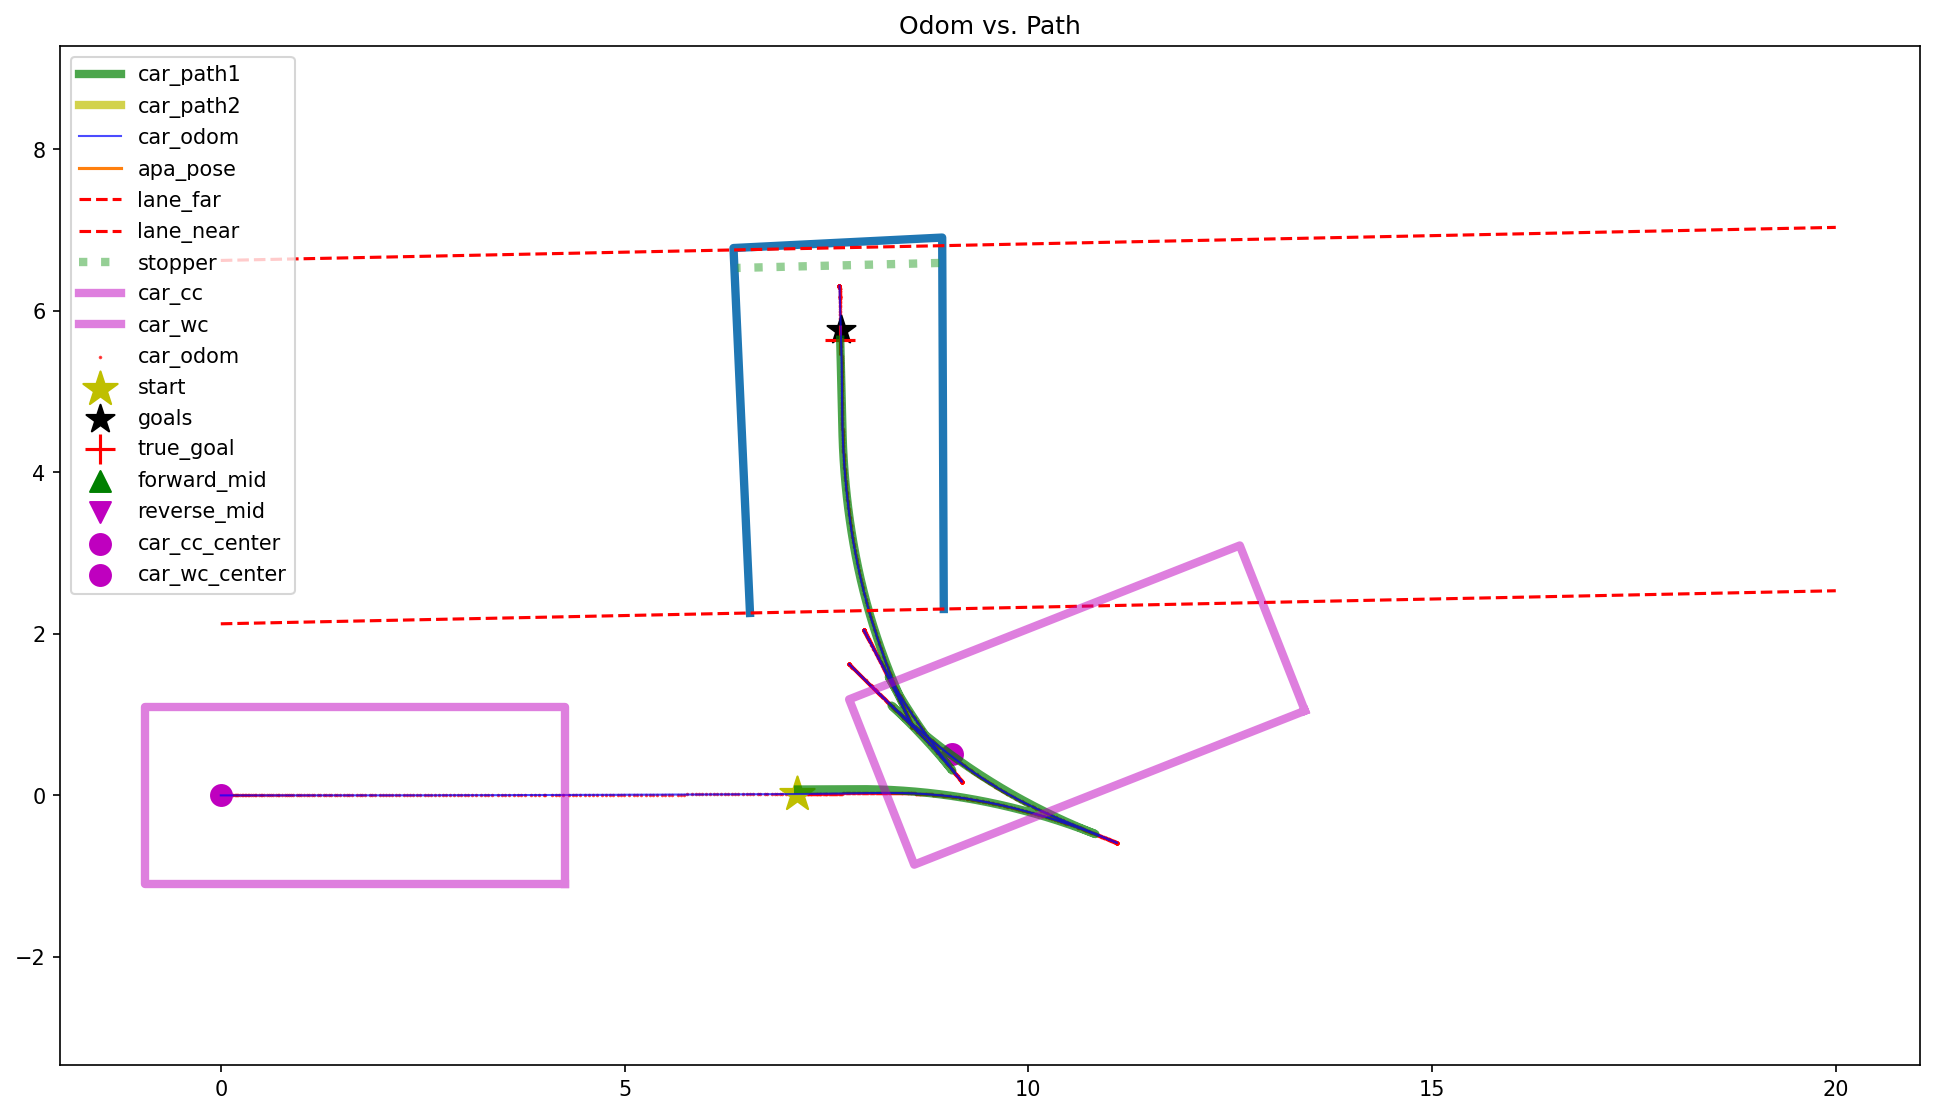

In [15]:
##############################################################################################################
######################### plot basic info.

# plt.figure(figsize=(8,10))
plt.figure(figsize=(16, 9), dpi=150)
# plt.figure(dpi=150)

plt.axis('equal')


# 1. plot computed path
plt.plot(path_carx, path_cary, label="car_path1", linewidth=4, alpha=0.7, color='g')
plt.plot(path2_carx, path2_cary, label="car_path2", linewidth=4, alpha=0.7, color='y')
# plt.plot(path3_carx, path3_cary, label="car_path3", linewidth=4)
# plt.plot(path4_carx, path4_cary, label="car_path4", linewidth=4)

# 2. plot odometry
print("odom length:\t", len(odom_x_car))
print("odom length half:\t", int(len(odom_x_car)/2))
plt.plot(odom_x_car, odom_y_car, label="car_odom", color="b", alpha=0.7, linewidth=1)
# plt.scatter(odom_x_car[0:700], odom_y_car[0:700], label="car_odom", color="b", alpha=0.7, s=1)
plt.scatter(odom_x_car, odom_y_car, label="car_odom", color="r", alpha=0.7, s=0.5)

# 3. plot odom start, goal
plt.scatter(odom_start_x, odom_start_y, label="start", marker='*', color='y', s=300)
plt.scatter(odom_goal_x, odom_goal_y, label="goals", marker='*', color='k', s=200)

# 4. plot parking slot points
plt.plot(parking_points_x, parking_points_y, linewidth=4)
print("parking_points_x:\t", parking_points_x)
print("parking_points_y:\t", parking_points_y)


# # 5. plot pillars
# try:
#     plt.plot(pillar_x, pillar_y, marker='.', markersize=100)
# except:
#     print("cannot plot pillar")

# 6. plot apa car post
plt.plot(apa_x_car, apa_y_car, label="apa_pose")

# 7. plot true goal
# plt.plot(true_goal_x, true_goal_y, label="true_goal", color="r")
plt.scatter(true_goal_x, true_goal_y, label="true_goal", marker='+', color='r', s=200)
print()
print("true_goal_x:\t", true_goal_x)
print("true_goal_y:\t", true_goal_y)
print("true_goal_t:\t", true_goal_theta)

# 4. plot forward mid
plt.scatter(forward_mid_x, forward_mid_y, label="forward_mid", marker='^', color='g', s=100)
print()
print("forward_mix_x:\t", forward_mid_x)
print("forward_mix_y:\t", forward_mid_y)
print("forward_mid_t:\t", forward_mid_theta)


# 5. plot reverse mid
plt.scatter(reverse_mid_x, reverse_mid_y, label="reverse_mid", marker='v', color='m', s=100)
print()
print("reverse_mix_x:\t", reverse_mid_x)
print("reverse_mix_y:\t", reverse_mid_y)
print("reverse_mid_t:\t", reverse_mid_theta)


##############################################################################################################
######################### plot lane-width info.

# plot lane-width
lane_width = 4.5
slot_point_near_x = [parking_points_x[0], parking_points_x[3]]  # x_near_1, x_near_2
slot_point_near_y = [parking_points_y[0], parking_points_y[3]]  # y_near_1, y_near_2
slot_point_far_x = [parking_points_x[0], parking_points_x[3]]  # x_far_1, x_far_2
slot_point_far_y = [parking_points_y[0] + lane_width, parking_points_y[3] + lane_width]  # y_far_1, y_far_2


# calculate far line
x_far_start = 0
y_far_start = 0
x_far_end = 20
y_far_end = 0

# for right side parking
# def solveY(x, y, x1, x2, y1, y2):
y_far_start = solveY(x_far_start, y_far_start, 
                     parking_points_x[3], parking_points_x[0], 
                     parking_points_y[3] + lane_width, parking_points_y[0] + lane_width)
y_far_end = solveY(x_far_end, y_far_end, 
                   parking_points_x[3], parking_points_x[0], 
                   parking_points_y[3] + lane_width, parking_points_y[0] + lane_width)
print("x_far_start:\t", x_far_start)
print("x_far_end:\t", x_far_end)
print("y_far_start:\t", y_far_start)
print("y_far_end:\t", y_far_end)

# for left side parking
# y_far_start = solveY(x_far_start, y_far_start, 
#                      parking_points_x[3], parking_points_x[0], 
#                      parking_points_y[3] - lane_width, parking_points_y[0] - lane_width)
# y_far_end = solveY(x_far_end, y_far_end, 
#                    parking_points_x[3], parking_points_x[0], 
#                    parking_points_y[3] - lane_width, parking_points_y[0] - lane_width)
# print("x_far_start:\t", x_far_start)
# print("x_far_end:\t", x_far_end)
# print("y_far_start:\t", y_far_start)
# print("y_far_end:\t", y_far_end)

x_far = [x_far_start, x_far_end]
y_far = [y_far_start, y_far_end]
plt.plot(x_far, y_far, label="lane_far", color="r", linestyle="dashed")


# calculate near line
x_near_start = 0
y_near_start = 0
x_near_end = 20
y_near_end = 0

# def solveY(x, y, x1, x2, y1, y2):
y_near_start = solveY(x_near_start, y_near_start, 
                     parking_points_x[3], parking_points_x[0], 
                     parking_points_y[3], parking_points_y[0])
y_near_end = solveY(x_near_end, y_near_end, 
                   parking_points_x[3], parking_points_x[0], 
                   parking_points_y[3], parking_points_y[0])
print("x_near_start:\t", x_near_start)
print("x_near_end:\t", x_near_end)
print("y_near_start:\t", y_near_start)
print("y_near_end:\t", y_near_end)

x_near = [x_near_start, x_near_end]
y_near = [y_near_start, y_near_end]

# slot_point_far_x = [parking_points_x[0], parking_points_x[3]]  # x_far_1, x_far_2
# slot_point_far_y = [parking_points_y[0] + lane_width, parking_points_y[3] + lane_width]  # y_far_1, y_far_2

plt.plot(x_near, y_near, label="lane_near", color="r", linestyle="dashed")
# plt.plot(slot_point_far_x, slot_point_far_y, label="slot_point_far", color="r", linestyle="dashed")


##############################################################################################################
######################### plot stopper info.

stopper_cc_x = [-2, -2]  # 世界坐标系原点
stopper_cc_y = [1.25, -1.25]
stopper_wc_x = []  # 当前车位坐标系中点
stopper_wc_y = []

th_stopper = slot_center_theta[0]  # 当前车位坐标系中点为旋转平移向量
tr_x_stopper = slot_center_apa_x[0]
tr_y_stopper = slot_center_apa_y[0]

# 为什么这个函数没有使用 return 也可以绘制出图像，因为传递的是 list（python没有值传递）
cc2wc_transform(stopper_cc_x, stopper_cc_y, 
                stopper_wc_x, stopper_wc_y, 
                th_stopper, tr_x_stopper, tr_y_stopper)
print("stopper_wc_x:\t", stopper_wc_x)
print("stopper_wc_y:\t", stopper_wc_y)


# draw stopper
plt.plot(stopper_wc_x, stopper_wc_y, 
     linewidth=4, alpha=0.5, linestyle="dotted", label="stopper")



##############################################################################################################
######################### plot car info.

car_body_box_init_x = [4.26, 4.26, -0.94, -0.94, 4.26, 0] # last is rear-wheel-center
car_body_box_init_y = [-1.1, 1.1, 1.1, -1.1, -1.1, 0] # last is rear-wheel-center

car_body_box_wc_x = []
car_body_box_wc_y = []

# bvs_3
# Line 94635: [2021-04-10 00:07:01.811] [tsl] [info] Current Pose(x, y, theta, phi): (15.0050, 0.431, 0.363028, 0.465741)
# odom_pick_x = [15.0050]
# odom_pick_y = [0.431]
# odom_pick_theta = [0.363028]

# bvs_2
# Line 89972: [2021-04-10 00:06:59.775] [tsl] [info] Current Pose(x, y, theta, phi): (15.484, 0.232, -0.132645, -0.280736)
# Line 106436: [2021-04-10 00:09:53.531] [tsl] [info] Current Pose(x, y, theta, phi): (10.662, 0.612, 0.441568, 0.501974) #0411
# Line 85350: [2021-04-10 00:10:02.062] [tsl] [info] Current Pose(x, y, theta, phi): (9.059, 0.51, 0.375246, 0.501974)


odom_pick_x = [9.059]
odom_pick_y = [0.51]
odom_pick_theta = [0.375246]

# odom pick point
tr_x_car = odom_pick_x[0]  # odom pick point
tr_y_car = odom_pick_y[0]
th_car = odom_pick_theta[0]


cc2wc_transform(car_body_box_init_x, car_body_box_init_y, 
                car_body_box_wc_x, car_body_box_wc_y,
                th_car, tr_x_car, tr_y_car)

# 1. plot car box wc
plt.plot(car_body_box_init_x[0:5], car_body_box_init_y[0:5], label="car_cc", linewidth=4, alpha=0.5, color='m')
plt.scatter(car_body_box_init_x[-1], car_body_box_init_y[-1], label="car_cc_center", marker='o', color='m', s=100)

plt.plot(car_body_box_wc_x[0:5], car_body_box_wc_y[0:5], label="car_wc", linewidth=4, alpha=0.5, color='m')
plt.scatter(car_body_box_wc_x[-1], car_body_box_wc_y[-1], label="car_wc_center", marker='o', color='m', s=100)



##############################################################################################################
######################### end of plot


plt.legend(loc="best")

plt.title("Odom vs. Path")

plt.show()


control_steer_min:	 -0.473669
control_steer_max:	 0.533878
odom_phi_min:	 -0.475044
odom_phi_max:	 0.504191
pub_steer_car_min:	 -0.474287
pub_steer_car_max:	 0.5


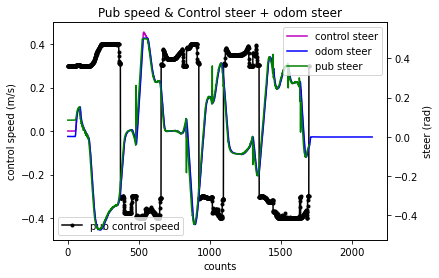

In [16]:
# plot control speed and control steer from PubControl (Car)

fig, ax3 = plt.subplots()

# pub control speed
ln4 = ax3.plot(pub_v_car, 'k.-', label = "pub control speed") # 
# plt.legend(loc="upper left")
plt.legend(loc="lower left")
ax3.set_ylabel("control speed (m/s)")
ax3.set_xlabel("counts")
plt.ylim(-0.5,0.5)

# control steer vs odom steer vs pub steer
ax4 = ax3.twinx()
ln5 = ax4.plot(control_steer_car, 'm', label = "control steer")
ln5 = ax4.plot(odom_phi_car, 'b', label = "odom steer", alpha=1)
ln5 = ax4.plot(pub_steer_car, 'g', label = "pub steer", alpha=1)


#

print("control_steer_min:\t", min(control_steer_car))
print("control_steer_max:\t", max(control_steer_car))
print("odom_phi_min:\t", min(odom_phi_car))
print("odom_phi_max:\t", max(odom_phi_car))
print("pub_steer_car_min:\t", min(pub_steer_car))
print("pub_steer_car_max:\t", max(pub_steer_car))

plt.legend(loc="upper right")
ax4.set_ylabel("steer (rad)")
# plt.xlim(0,2500)
plt.title("Pub speed & Control steer + odom steer")
plt.show()

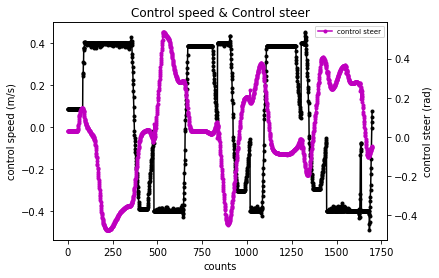

In [17]:
# plot control speed and control steer from ComputeControlValue (Car)

fig, ax3 = plt.subplots()
ln4 = ax3.plot(control_v_car, 'k.-', label = "control speed")
ax3.set_ylabel("control speed (m/s)")
ax3.set_xlabel("counts")
#plt.ylim(0,0.3)

ax4 = ax3.twinx()
ln5 = ax4.plot(control_steer_car, 'm.-', label = "control steer")
ax4.set_ylabel("control steer (rad)")
#plt.xlim(0,400)
plt.title("Control speed & Control steer")
plt.legend(loc='upper right',fontsize='x-small')
plt.show()

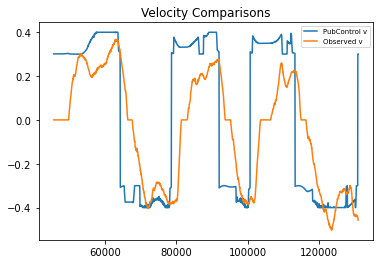

In [18]:
# manually calculate actual velocity

real_car_v = []
for t in control_car_time:
    try:
        i = car_time.index(t)
    except ValueError:
        real_car_v.append(real_car_v[len(real_car_v)-1])
        continue
    prev_i = i - 10
    dt = car_time[i] - car_time[prev_i]
    
    
    cosT = math.cos(odom_theta_car[prev_i])
    sinT = math.sin(odom_theta_car[prev_i])
    dx = odom_x_car[i] - odom_x_car[prev_i]
    dy = odom_y_car[i] - odom_y_car[prev_i]
    dx_copy = dx
    dx = cosT*dx + sinT*dy
    dy = -sinT*dx_copy + cosT*dy
    d = math.sqrt(dx*dx + dy*dy)
    if (dt == 0):
        real_car_v.append(0)
    else:
        if (dx >= 0):
            real_car_v.append(d/dt*1000)
        else:
            real_car_v.append(d/dt*-1000) 

# plot control with actual speed
# plt.plot(control_car_time, control_v_car, label="ComputeControl v")
plt.plot(pub_car_time, pub_v_car, label="PubControl v")
# plt.plot(rc_time, apa_rc_speed, label="apa rc v")
plt.plot(control_car_time, real_car_v, label="Observed v")
plt.title("Velocity Comparisons")
plt.legend(loc='upper right',fontsize='x-small')
# plt.legend(loc='lower left', fontsize='x-small')
# plt.xlim(12000,26000)
plt.show()

## plot comparison b/w mcu odom and ts odom